# 1. Data Import

As always, we begin by importing the necessary libraries, loading the dataset for analysis, and displaying the first few rows to better understand what's in the dataset. We will also create our outcome variable, `nap_occurred`, to indicate if there was a daytime nap on each day.

In [1]:
import pandas as pd

# Load energy scores dataset
labeled_df = pd.read_csv("data/shr_v_temp_phase.csv")

# Load daytime naps
daytime_nap = pd.read_csv("data/daytime_naps.csv")

# Load nighttime sleep sessions
nighttime_sleep = pd.read_csv("data/nighttime_sleep.csv")
nighttime_sleep_features_df = nighttime_sleep[
    [
        "local_end_time_date",
        "local_start_time_hour",
        "deep_sleep_duration",
        "total_rem_duration",
        "sleep_cycle"
    ]
].copy()

# Merge nighttime sleep with energy scores
labeled_df = pd.merge(
    labeled_df,
    nighttime_sleep_features_df,
    how='left',
    left_on='day_time',
    right_on='local_end_time_date'
)

# Convert day_time and nap start dates to datetime
labeled_df['day_time'] = pd.to_datetime(labeled_df['day_time'])
daytime_nap['local_start_time_date'] = pd.to_datetime(
    daytime_nap['local_start_time_date'])

# Create a nap label (outcome variable): 1 if nap occurred on that date, 0 otherwise
nap_dates = set(daytime_nap['local_start_time_date'])
labeled_df['nap_occurred'] = labeled_df['day_time'].isin(nap_dates).astype(int)

labeled_df.head(10)

,day_time,shr_value,shrv_value,sleep_duration,temperature,phase,local_end_time_date,local_start_time_hour,deep_sleep_duration,total_rem_duration,sleep_cycle,nap_occurred
0,2024-12-17,64.026665,43.163870,22187142,NaN,luteal,2024-12-17,3,37.0,50.0,2.0,0
1,2024-12-18,69.211180,41.222710,23627142,36.58,luteal,2024-12-18,22,80.0,113.0,5.0,0
2,2024-12-19,69.405495,37.721830,24017142,36.34,luteal,2024-12-19,22,75.0,98.0,4.0,1
3,2024-12-20,70.991020,41.284610,24510000,36.46,luteal,2024-12-20,23,62.0,108.0,5.0,0
4,2024-12-21,70.791840,34.162390,24904285,36.53,luteal,2024-12-21,23,80.0,98.0,4.0,1
5,2024-12-22,70.806230,35.681026,24810000,36.59,luteal,2024-12-22,22,96.0,142.0,5.0,1
6,2024-12-23,68.029305,38.048187,25804285,36.71,luteal,2024-12-23,23,51.0,83.0,4.0,1
7,2024-12-24,66.304184,38.915096,27090000,36.61,luteal,2024-12-24,23,60.0,102.0,7.0,0
8,2024-12-25,71.026950,38.572796,27231428,36.57,luteal,2024-12-25,23,83.0,119.0,4.0,0
9,2024-12-26,69.845830,38.265750,26365714,36.53,luteal,2024-12-26,2,75.0,55.0,3.0,0


# 2. Exploratory Data Analysis

In this step, I'm curious about how the number of daytime naps is distributed between my menstrual phases (follicular/luteal) as well as how the independent variables (sleeping HR, sleeping HRV, etc.) are distributed within each group (Nap/No Nap).

A simple bar graph shows that the number of daytime naps during my follicular phase is two times more than that during my luteal phase.

/var/folders/15/y9dr2qsj3zz1nfvhps0zv4pc0000gn/T/ipykernel_68684/975312670.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phase_nap_counts = labeled_df.groupby('phase')['nap_occurred'].sum()


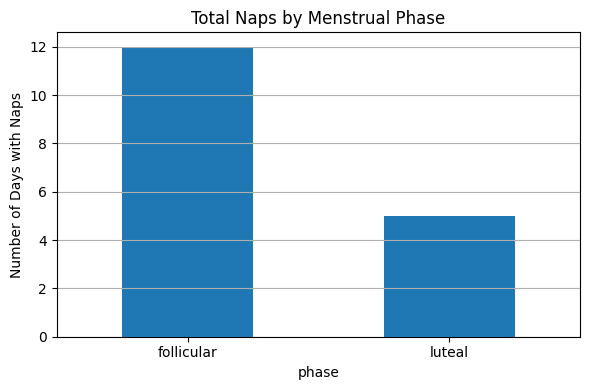

In [2]:
import matplotlib.pyplot as plt

# Convert 'phase' to category for plotting
labeled_df['phase'] = labeled_df['phase'].astype('category')

# EDA 1: Nap frequency by menstrual phase
phase_nap_counts = labeled_df.groupby('phase')['nap_occurred'].sum()

plt.figure(figsize=(6, 4))
phase_nap_counts.plot(kind='bar')
plt.title("Total Naps by Menstrual Phase")
plt.ylabel("Number of Days with Naps")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

A visualization of my sleeping HR, HRV, and total sleep duration shows some skew in both Nap and No Nap groups.

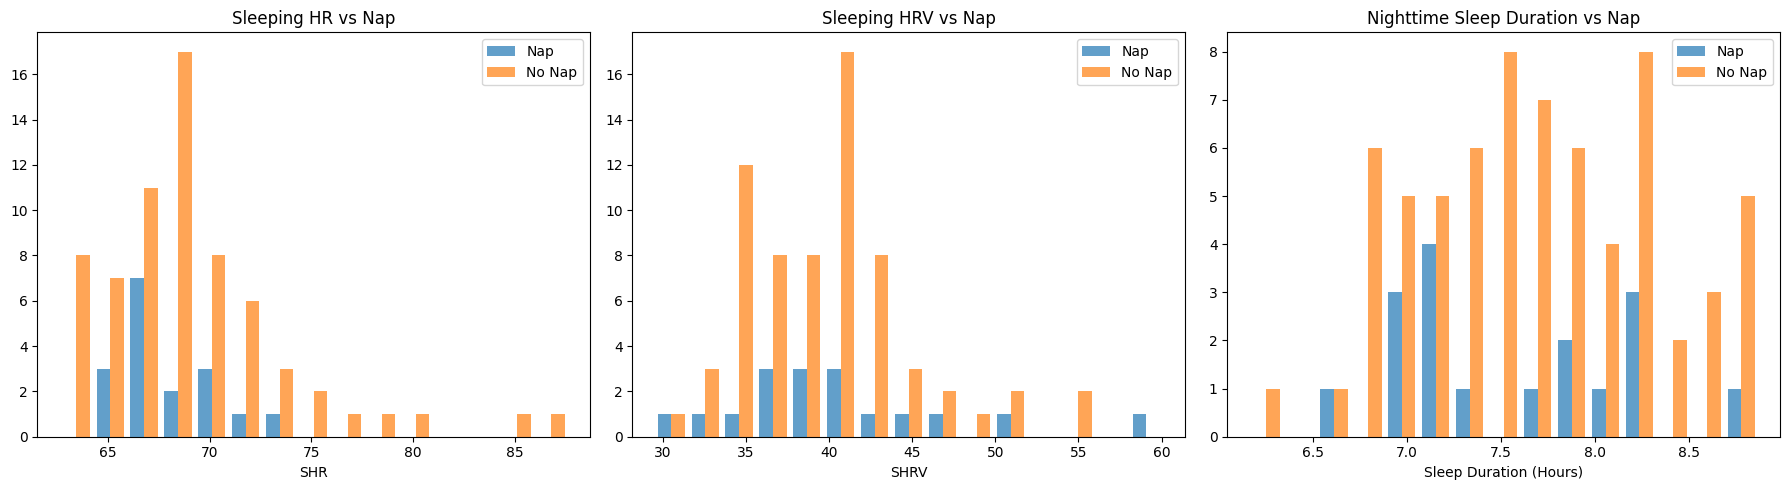

In [3]:
# EDA 2: Distribution of sleep metrics vs nap
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].hist([labeled_df[labeled_df['nap_occurred'] == 1]['shr_value'],
             labeled_df[labeled_df['nap_occurred'] == 0]['shr_value']], 
            bins=15, label=['Nap', 'No Nap'], alpha=0.7)
axs[0].set_title("Sleeping HR vs Nap")
axs[0].set_xlabel("SHR")
axs[0].legend()

axs[1].hist([labeled_df[labeled_df['nap_occurred'] == 1]['shrv_value'],
             labeled_df[labeled_df['nap_occurred'] == 0]['shrv_value']], 
            bins=15, label=['Nap', 'No Nap'], alpha=0.7)
axs[1].set_title("Sleeping HRV vs Nap")
axs[1].set_xlabel("SHRV")
axs[1].legend()

axs[2].hist([labeled_df[labeled_df['nap_occurred'] == 1]['sleep_duration'] / 3600000,
             labeled_df[labeled_df['nap_occurred'] == 0]['sleep_duration'] / 3600000], 
            bins=15, label=['Nap', 'No Nap'], alpha=0.7)
axs[2].set_title("Nighttime Sleep Duration vs Nap")
axs[2].set_xlabel("Sleep Duration (Hours)")
axs[2].legend()

plt.tight_layout()
plt.show()


# Feature Engineering (Days Since Last Nap)

Given that more naps occur during the follicular phase than the luteal phase, it is likely that the naps will occur within a few days of each other (i.e. the same phase) instead of being evenly distributed across the menstrual cycle. Therefore, we will engineer a feature that tracks the number of days since the last nap. For the first row, since we do not have prior data, we will fill it with the maximum number of days that we have encountered in our dataset (17 days + 1).

In [4]:
import numpy as np

# Start with a copy of the labeled dataset
fe_df = labeled_df.copy()
fe_df = fe_df.sort_values('day_time').reset_index(drop=True)

# Feature 1: Days since last nap
fe_df['days_since_nap'] = np.nan
last_nap_day = None
for i, row in fe_df.iterrows():
    if row['nap_occurred'] == 1:
        fe_df.at[i, 'days_since_nap'] = 0
        last_nap_day = i
    elif last_nap_day is not None:
        fe_df.at[i, 'days_since_nap'] = i - last_nap_day

# Fill missing with max+1
fe_df['days_since_nap'] = fe_df['days_since_nap'].fillna(fe_df['days_since_nap'].max() + 1)

fe_df.head()

,day_time,shr_value,shrv_value,sleep_duration,temperature,phase,local_end_time_date,local_start_time_hour,deep_sleep_duration,total_rem_duration,sleep_cycle,nap_occurred,days_since_nap
0,2024-12-17,64.026665,43.16387,22187142,NaN,luteal,2024-12-17,3,37.0,50.0,2.0,0,18.0
1,2024-12-18,69.211180,41.22271,23627142,36.58,luteal,2024-12-18,22,80.0,113.0,5.0,0,18.0
2,2024-12-19,69.405495,37.72183,24017142,36.34,luteal,2024-12-19,22,75.0,98.0,4.0,1,0.0
3,2024-12-20,70.991020,41.28461,24510000,36.46,luteal,2024-12-20,23,62.0,108.0,5.0,0,1.0
4,2024-12-21,70.791840,34.16239,24904285,36.53,luteal,2024-12-21,23,80.0,98.0,4.0,1,0.0


# LazyPredict for Classification

`lazypredict` is a tool that builds and evaluates a lot of basic classification models (e.g. LogisticRegression, KNeighborsClassifier, etc.) without requiring a lot of code to be written.

This helps you quickly understand which models work better, without getting into any parameter tuning.

In [5]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler

# Define features (independent variables) and target (nap or not)
fe_df = fe_df.dropna()
FEATURES = [
    "shr_value",
    "shrv_value",
    "sleep_duration",
    "temperature",
    "local_start_time_hour",
    "deep_sleep_duration",
    "total_rem_duration",
    "sleep_cycle",
    "days_since_nap",
]
X = fe_df[FEATURES].copy()

# Convert categorical features to numerical
y = fe_df["nap_occurred"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Run LazyClassifier
clf = LazyClassifier(ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Show results
models

100%|██████████| 30/30 [00:00<00:00, 79.08it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.02
GaussianNB,1.00,1.00,1.00,1.00,0.01
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.01
BaggingClassifier,1.00,1.00,1.00,1.00,0.02
ExtraTreeClassifier,1.00,1.00,1.00,1.00,0.01
RandomForestClassifier,1.00,1.00,1.00,1.00,0.08
PassiveAggressiveClassifier,0.96,0.90,0.90,0.96,0.01
LinearSVC,0.92,0.87,0.87,0.92,0.01
Perceptron,0.83,0.75,0.75,0.83,0.01


# Further Analysis: LogisticRegression

From the above table, it seems that several models—from AdaBoostClassifier to RandomForestClassifier—are prone to overfitting. I'll be choosing LogisticRegression for further analysis as 1) it's one of the easier models to interpret, and 2) it seems to be fitting well compared to other models.

To proceed, we'll build LogisticRegression from scratch: fit the model to our scaled data and evaluate it. We have a decent test accuracy of 87.5% and a ROC-AUC of 0.7, meaning that our model is able to predict whether we'll nap on a given day (from that day's sleeping HR, HRV, etc. data) fairly well.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score


# We already scaled the data above so we don't need to do it again
model = LogisticRegression()

# Fit the pipeline
fitted_model = model.fit(X_train, y_train)


# Model evaluation
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # Print accuracy score
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Print ROC AUC score (??? Needs investigation)
    print("ROC AUC:", roc_auc_score(y_test, y_pred))


# Evaluate the model
evaluate_model(fitted_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.40      0.57         5

    accuracy                           0.88        24
   macro avg       0.93      0.70      0.75        24
weighted avg       0.89      0.88      0.85        24

[[19  0]
 [ 3  2]]
Accuracy: 0.875
ROC AUC: 0.7


# SHAP Analysis

According to [DataCamp's Introduction to SHAP values](https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability):

> SHAP (SHapley Additive exPlanations) values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.

Thus far, we've defined our outcome, `nap_occurred`, as 1 for a daytime nap and 0 for no daytime nap. Thus, a positive value on the x-axis means a contribution *towards* a nap occurring. Meanwhile, the values (indicated by colors—high VS low) represent the quantity of a given feature variable. For example, a low (blue-colored) `days_since_nap` indicates a small number of days since the last nap; a red `shr_value` indicates a high Sleeping HR value for that given day.

From the graph, we see that:
- **Small number of days since last nap contribute greatly towards a nap occurrence**: I tend to have daytime naps across several (almost-consecutive) days. This would make sense from the menstrual phase perspective, where I've taken more naps during the follicular phase than the luteal phase.
    - The phase perspective also shows up in `shr_value` and `shrv_value`—during the follicular phase, sleeping HR tends to be lower (blue) and sleeping HRV tends to be higher (red)
- **Longer deep sleep duration has a larger contribution towards a nap occurrence**: Deep sleep is associated with physical recovery, such as tissue repair and hormone regulation. It could be that a longer deep sleep duration is indicative of a need for repair, and a nap is one way to achieve that. 
- **Shorter REM sleep duration has a larger contribution towards a nap occurrence**: REM sleep is associated with mental recovery, such as memory consolidation and mood regulation. Not having enough REM sleep can make one feel sleepy and less alert, which makes napping more tempting.


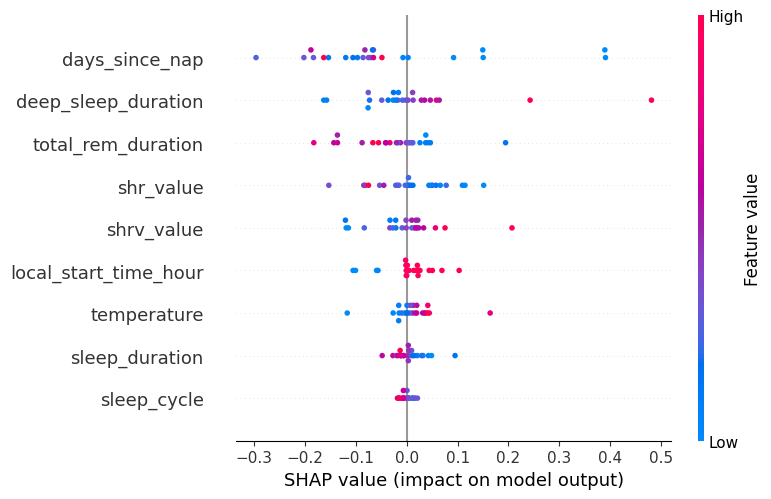

In [7]:
import shap

# Use SHAP's LinearExplainer for logistic regression
explainer = shap.Explainer(model.predict, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=FEATURES)